<center>
 <h1>Cash Management Optimisation for ATM Network</h1>
<center>
<hr>
<center>
    Group P Implementation File <br>
    Date: 08 / 11 / 2024
<center>

In [478]:
###################################################################################################################
# LIBRARY IMPORTS
###################################################################################################################

import pandas as pd
import seaborn as sns
import numpy as np
import itertools
from statsmodels.formula.api import ols
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import warnings

# Ignore Warnings
warnings.filterwarnings("ignore")

###################################################################################################################

In [541]:
###################################################################################################################
# DATASETS
###################################################################################################################

# ATM_test: for evaluating models
ATM_test = pd.read_csv('ATM_test.csv') 

# ATM_sample: for training models
df = pd.read_csv('ATM_sample.csv')

###################################################################################################################

# Splitting ATM_sample into 3 clusters

# Cluster 1: "Downtown AND Holiday AND Center"
cluster1 = df[(df.Downtown == 1) & (df.Workday == 0) & (df.Center == 1)]

# Cluster 2: "Downtown AND Holiday AND Not Center" + "Downtown and Workday"
cluster2 = df[(df.Downtown == 1) & (((df.Workday == 0) & (df.Center == 0)) | (df.Workday == 1))]

# Cluster 3: "Not Downtown"
cluster3 = df[(df.Downtown == 0)]

###################################################################################################################

# Define a small constant to add to log terms to avoid log 0 
epsilon = 1e-6

In [494]:
###################################################################################################################
# FUNCTIONS
###################################################################################################################

def enhance_data(df):
    df_enhanced = df.copy()

    # Define a small constant to add to log terms to avoid log 0 
    epsilon = 1e-6

    # Polynomial terms for Shops and ATMs
    df_enhanced['ShopsSquared'] = df['Shops'] ** 2
    df_enhanced['ShopsCubed'] = df['Shops'] ** 3
    df_enhanced['ATMsSquared'] = df['ATMs'] ** 2
    df_enhanced['ATMsCubed'] = df['ATMs'] ** 3

    # Log terms for Shops and ATMs
    df_enhanced['log_Shops'] = np.log(df['Shops'] + epsilon)
    df_enhanced['log_ATMs'] = np.log(df['ATMs'] + epsilon)

    # Two-term interactions
    df_enhanced['Shops_ATMs'] = df['Shops'] * df['ATMs']
    df_enhanced['Shops_High'] = df['Shops'] * df['High']
    df_enhanced['Shops_Center'] = df['Shops'] * df['Center']
    df_enhanced['Shops_Workday'] = df['Shops'] * df['Workday']
    df_enhanced['Shops_ATMsSquared'] = df['Shops'] * df_enhanced['ATMsSquared']
    df_enhanced['Shops_ATMsCubed'] = df['Shops'] * df_enhanced['ATMsCubed']
    df_enhanced['Shops_log_Shops'] = df['Shops'] * np.log(df['Shops'] + epsilon)
    df_enhanced['Shops_log_ATMs'] = df['Shops'] * np.log(df['ATMs'] + epsilon)
    df_enhanced['ATMs_High'] = df['ATMs'] * df['High']
    df_enhanced['ATMs_Center'] = df['ATMs'] * df['Center']
    df_enhanced['ATMs_Workday'] = df['ATMs'] * df['Workday']
    df_enhanced['ATMs_ShopsSquared'] = df['ATMs'] * df_enhanced['ShopsSquared']
    df_enhanced['ATMs_ShopsCubed'] = df['ATMs'] * df_enhanced['ShopsCubed']
    df_enhanced['ATMs_log_Shops'] = df['ATMs'] * np.log(df['Shops'] + epsilon)
    df_enhanced['ATMs_log_ATMs'] = df['ATMs'] * np.log(df['ATMs'] + epsilon)
    df_enhanced['High_Center'] = df['High'] * df['Center']
    df_enhanced['High_Workday'] = df['High'] * df['Workday']
    df_enhanced['High_ShopsSquared'] = df['High'] * df_enhanced['ShopsSquared']
    df_enhanced['High_ShopsCubed'] = df['High'] * df_enhanced['ShopsCubed']
    df_enhanced['High_ATMsSquared'] = df['High'] * df_enhanced['ATMsSquared']
    df_enhanced['High_ATMsCubed'] = df['High'] * df_enhanced['ATMsCubed']
    df_enhanced['High_log_Shops'] = df['High'] * np.log(df['Shops'] + epsilon)
    df_enhanced['High_log_ATMs'] = df['High'] * np.log(df['ATMs'] + epsilon)
    df_enhanced['Workday_Center'] = df['Workday'] * df['Center']
    df_enhanced['Workday_ShopsSquared'] = df['Workday'] * df_enhanced['ShopsSquared']
    df_enhanced['Workday_ShopsCubed'] = df['Workday'] * df_enhanced['ShopsCubed']
    df_enhanced['Workday_ATMsSquared'] = df['Workday'] * df_enhanced['ATMsSquared']
    df_enhanced['Workday_ATMsCubed'] = df['Workday'] * df_enhanced['ATMsCubed']
    df_enhanced['Workday_log_Shops'] = df['Workday'] * np.log(df['Shops'] + epsilon)
    df_enhanced['Workday_log_ATMs'] = df['Workday'] * np.log(df['ATMs'] + epsilon)
    df_enhanced['Center_ShopsSquared'] = df['Center'] * df_enhanced['ShopsSquared']
    df_enhanced['Center_ShopsCubed'] = df['Center'] * df_enhanced['ShopsCubed']
    df_enhanced['Center_ATMsSquared'] = df['Center'] * df_enhanced['ATMsSquared']
    df_enhanced['Center_ATMsCubed'] = df['Center'] * df_enhanced['ATMsCubed']
    df_enhanced['Center_log_Shops'] = df['Center'] * np.log(df['Shops'] + epsilon)
    df_enhanced['Center_log_ATMs'] = df['Center'] * np.log(df['ATMs'] + epsilon)
    df_enhanced['ShopsSquared_ATMsSquared'] = df_enhanced['ShopsSquared'] * df_enhanced['ATMsSquared']
    df_enhanced['ShopsSquared_ATMsCubed'] = df_enhanced['ShopsSquared'] * df_enhanced['ATMsCubed']
    df_enhanced['ShopsSquared_log_Shops'] = df_enhanced['ShopsSquared'] * np.log(df['Shops'] + epsilon)
    df_enhanced['ShopsSquared_log_ATMs'] = df_enhanced['ShopsSquared'] * np.log(df['ATMs'] + epsilon)
    df_enhanced['ATMsSquared_ShopsCubed'] = df_enhanced['ATMsSquared'] * df_enhanced['ShopsCubed']
    df_enhanced['ATMsSquared_log_Shops'] = df_enhanced['ATMsSquared'] * np.log(df['Shops'] + epsilon)
    df_enhanced['ATMsSquared_log_ATMs'] = df_enhanced['ATMsSquared'] * np.log(df['ATMs'] + epsilon)
    df_enhanced['ShopsCubed_ATMsCubed'] = df_enhanced['ShopsCubed'] * df_enhanced['ATMsCubed']
    df_enhanced['ShopsCubed_log_Shops'] = df_enhanced['ShopsCubed'] * np.log(df['Shops'] + epsilon)
    df_enhanced['ShopsCubed_log_ATMs'] = df_enhanced['ShopsCubed'] * np.log(df['ATMs'] + epsilon)
    df_enhanced['ATMsCubed_log_Shops'] = df_enhanced['ATMsCubed'] * np.log(df['Shops'] + epsilon)
    df_enhanced['ATMsCubed_log_ATMs'] = df_enhanced['ATMsCubed'] * np.log(df['ATMs'] + epsilon)
    df_enhanced['log_Shops_log_ATMs'] = np.log(df['Shops'] + epsilon) * np.log(df['ATMs'] + epsilon)
    
    return df_enhanced

###################################################################################################################
def test_MSE(model, test):
    predictions = model.predict(test)
    mse = np.mean((test['Withdraw'] - predictions) ** 2)
    return mse

###################################################################################################################

def best_subset_selection(predictors, train, test):
    # Initialize lists to store metrics
    test_mse = []

    # Null model with just the intercept
    formula = 'Withdraw ~ 1'
    model = ols(formula, data=train).fit()

    test_mse.append(test_MSE(model, test))

    # Initialize best metrics with the null model
    best_test_mse = test_mse[-1]
    best_model_test_mse = formula

    # Iterate over all combinations of predictors
    for i in range(1, len(predictors.columns) + 1):

        # Reintialise best_train_mse for each i
        best_train_mse = np.inf

        for combo in itertools.combinations(predictors.columns, i):
            # Create the model formula
            formula = f'Withdraw ~ {" + ".join(combo)}'
            model = ols(formula, data=train).fit()
            train_mse =  np.mean(model.resid ** 2)

            #use train MSE to select the best set for a given number of predictors i

            if train_mse < best_train_mse:
                best_model_train_mse = formula
                best_model_fit_train_mse = model
                best_train_mse = train_mse

        # once the best set was found for given i compute test mse
        test_mse.append(test_MSE(best_model_fit_train_mse, test))

        # Update best model based on test_mse if current model is better

        if test_mse[-1] < best_test_mse:
                best_model_test_mse = best_model_train_mse
                best_test_mse = test_mse[-1]
                best_p_test = i + 1

    return best_model_test_mse
    
###################################################################################################################

def get_formula(model):
    intercept = model.params['Intercept']
    coefficients = model.params.drop('Intercept')
    formula = f"Withdraw = {intercept:.4f} + " + " + ".join([f"({coeff:.4f}*{var})" 
                                                                for var, coeff in coefficients.items()])
    return formula

###################################################################################################################

def get_features(model):
    features = model.params.index.tolist()

    # Remove the intercept (if present)
    if 'Intercept' in features:
        features.remove('Intercept')

    return features

###################################################################################################################

def cross_validation_mse(dataset, selected_features):

    # Construct formula for OLS
    formula = f"Withdraw ~ " + " + ".join(selected_features)
    
    # Set up cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    current_fold = 1
    mse_scores = []
    
    # Perform cross-validation
    for train_index, test_index in kf.split(dataset):
        # Split data into train and test sets for this fold
        train_data = dataset.iloc[train_index]
        test_data = dataset.iloc[test_index]
        
        # Fit OLS model on the training data using formula
        model = ols(formula, data=train_data).fit()
        
        # Predict on the test data and calculate MSE
        mse_scores.append(test_MSE(model,test_data))
        print(f"CV Test MSE Fold {current_fold}: {test_MSE(model,test_data):.4f}")
        
        current_fold = current_fold + 1
     
    # Calculate the average MSE across all folds
    mean_mse = np.mean(mse_scores)    
    return mean_mse

###################################################################################################################

def forward_selection(predictors, train, test):

    # Initialize lists to store metrics
    mse = []
    p = []

    # Null model with just the intercept
    formula = 'Withdraw ~ 1'
    model = ols(formula, data = train).fit()
    mse.append(test_MSE(model, test))
    p.append(1)

    # Initialize best metrics for each number of predictors 
    # Starting with the null model
    best_mses = [test_MSE(model, test)]
    best_models = [formula]

    remaining_covariates = list(predictors.columns)

    # Iterate over all number of predictors
    for i in range(1, len(predictors.columns) + 1):
        # These will store the current best mse and model 
        # for each number of predictors
        best_mse = np.inf 
        best_model = ''
        # Iterate over all remaining possible predictors
        for covariate in remaining_covariates:
            # Add covariate as a predictor
            new_formula = formula + ' + ' + covariate
            model = ols(new_formula, data = train).fit()

            # Store the MSE and number of parameters using append
            mse.append(test_MSE(model, test))
            p.append(i + 1)

            # Update best MSE model if current model is better
            if test_MSE(model, test) < best_mse:
                best_model = formula
                best_predictor = covariate
                best_mse = test_MSE(model, test)

        # Add the best model from this step to list 
        best_mses.append(best_mse)
        best_models.append(best_model)
        # Remove the predictor used from the remaining possible predictors
        remaining_covariates.remove(best_predictor)
        # and update the formula to include the best predictor from this step
        formula += f' + {best_predictor}'
        
        # Find the overall best model according to test MSE
        best_p = np.argmin(best_mses)
        best_model = best_models[best_p]
        best_mse = min(best_mses)
        
    return best_model

###################################################################################################################

def compute_test_error(cluster1_model, cluster2_model, cluster3_model, test):
    
    # Cluster 1
    test1 = test[(test.Downtown == 1) & (test.Workday == 0) & (test.Center == 1)]
    
    # Cluster 2
    test2 = test[(test.Downtown == 1) & (((test.Workday == 0) & (test.Center == 0)) | (test.Workday == 1))]

    # Cluster 3
    test3 = test[(test.Downtown == 0)]
    
    predictions1 = cluster1_model.predict(test1)
    predictions2 = cluster2_model.predict(test2)
    predictions3 = cluster3_model.predict(test3)
    
    # Calculate squared residuals for each cluster
    residuals1 = (test1['Withdraw'] - predictions1) ** 2
    residuals2 = (test2['Withdraw'] - predictions2) ** 2
    residuals3 = (test3['Withdraw'] - predictions3) ** 2
    
    # Concatenate residuals into a single Series
    residuals_test = pd.concat([residuals1, residuals2, residuals3])
    
    return np.mean(residuals_test)

<center>
 <h2>Exploratory Data Analysis</h2>
<center>

### Scatterplots of Entire Dataset and Individual Clusters

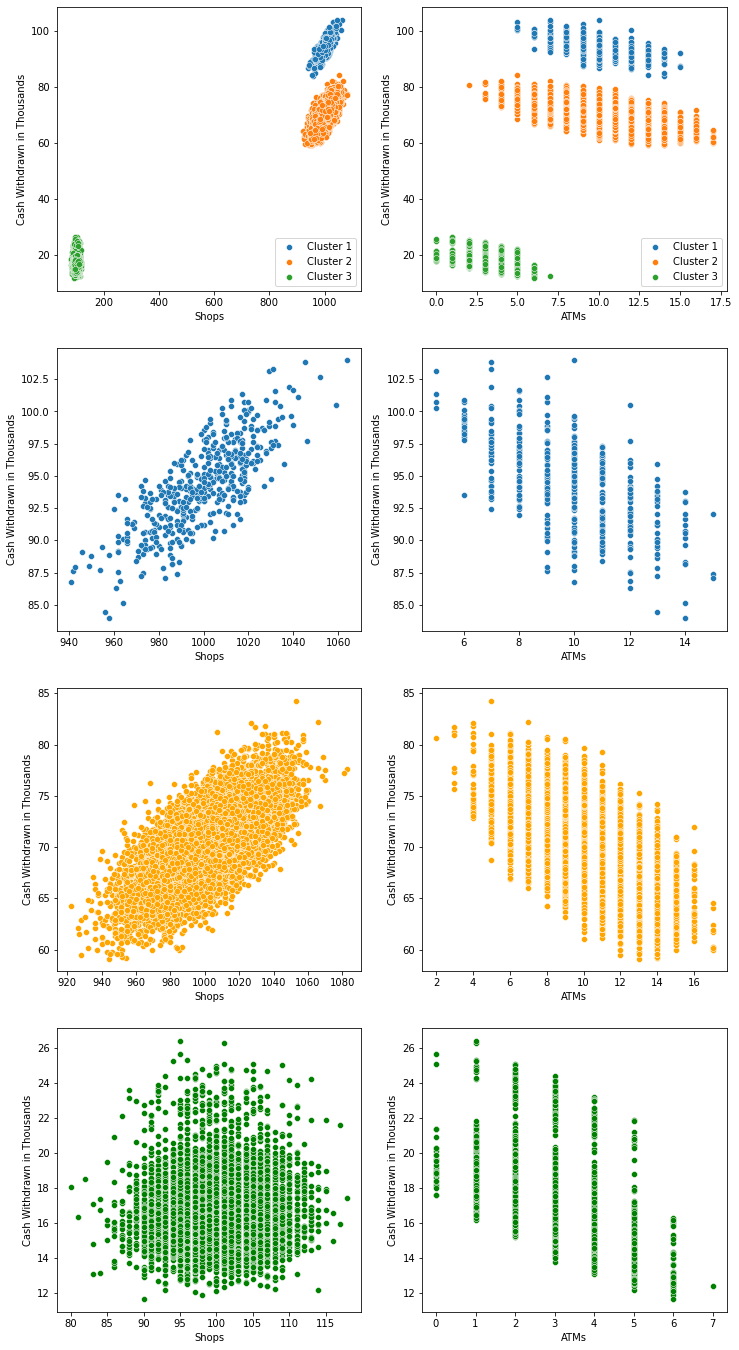

In [542]:
plt.figure(figsize=(12, 24))

# Subplot 1: Entire Datasest Shops vs Withdraw
plt.subplot(4, 2,1)
sns.scatterplot(x = 'Shops', y = 'Withdraw', data = cluster1, label='Cluster 1')
sns.scatterplot(x = 'Shops', y = 'Withdraw', data = cluster2, label='Cluster 2')
sns.scatterplot(x = 'Shops', y = 'Withdraw', data = cluster3, label='Cluster 3')
plt.ylabel('Cash Withdrawn in Thousands')
plt.legend(loc='lower right')

# Subplot 2: Entire Dataset ATMs vs Withdraw
plt.subplot(4, 2, 2)
sns.scatterplot(x = 'ATMs', y = 'Withdraw', data = cluster1, label='Cluster 1')
sns.scatterplot(x = 'ATMs', y = 'Withdraw', data = cluster2, label='Cluster 2')
sns.scatterplot(x = 'ATMs', y = 'Withdraw', data = cluster3, label='Cluster 3')
plt.ylabel('Cash Withdrawn in Thousands')
plt.legend(loc='lower right')

# Subplot 3: Cluster 1 Shops vs Withdraw
plt.subplot(4, 2, 3)
sns.scatterplot(x = 'Shops', y = 'Withdraw', data = cluster1)
plt.ylabel('Cash Withdrawn in Thousands')

# Subplot 4: Cluster 1 ATMs vs Withdraw
plt.subplot(4, 2, 4)
sns.scatterplot(x = 'ATMs', y = 'Withdraw', data = cluster1)
plt.ylabel('Cash Withdrawn in Thousands')

# Subplot 5: Cluster 2 Shops vs Withdraw
plt.subplot(4, 2, 5)
sns.scatterplot(x = 'Shops', y = 'Withdraw', data = cluster2, color='orange')
plt.ylabel('Cash Withdrawn in Thousands')

# Subplot 6: Cluster 2 ATMs vs Withdraw
plt.subplot(4, 2, 6)
sns.scatterplot(x = 'ATMs', y = 'Withdraw', data = cluster2, color='orange')
plt.ylabel('Cash Withdrawn in Thousands')

# Subplot 7: Cluster 3 Shops vs Withdraw
plt.subplot(4, 2, 7)
sns.scatterplot(x = 'Shops', y = 'Withdraw', data = cluster3, color='green')
plt.ylabel('Cash Withdrawn in Thousands')

# Subplot 8: Cluster 3 ATMs vs Withdraw
plt.subplot(4, 2, 8)
sns.scatterplot(x = 'ATMs', y = 'Withdraw', data = cluster3, color='green')
plt.ylabel('Cash Withdrawn in Thousands')

plt.show()

### Heatmap of Entire Dataset and Individual Clusters

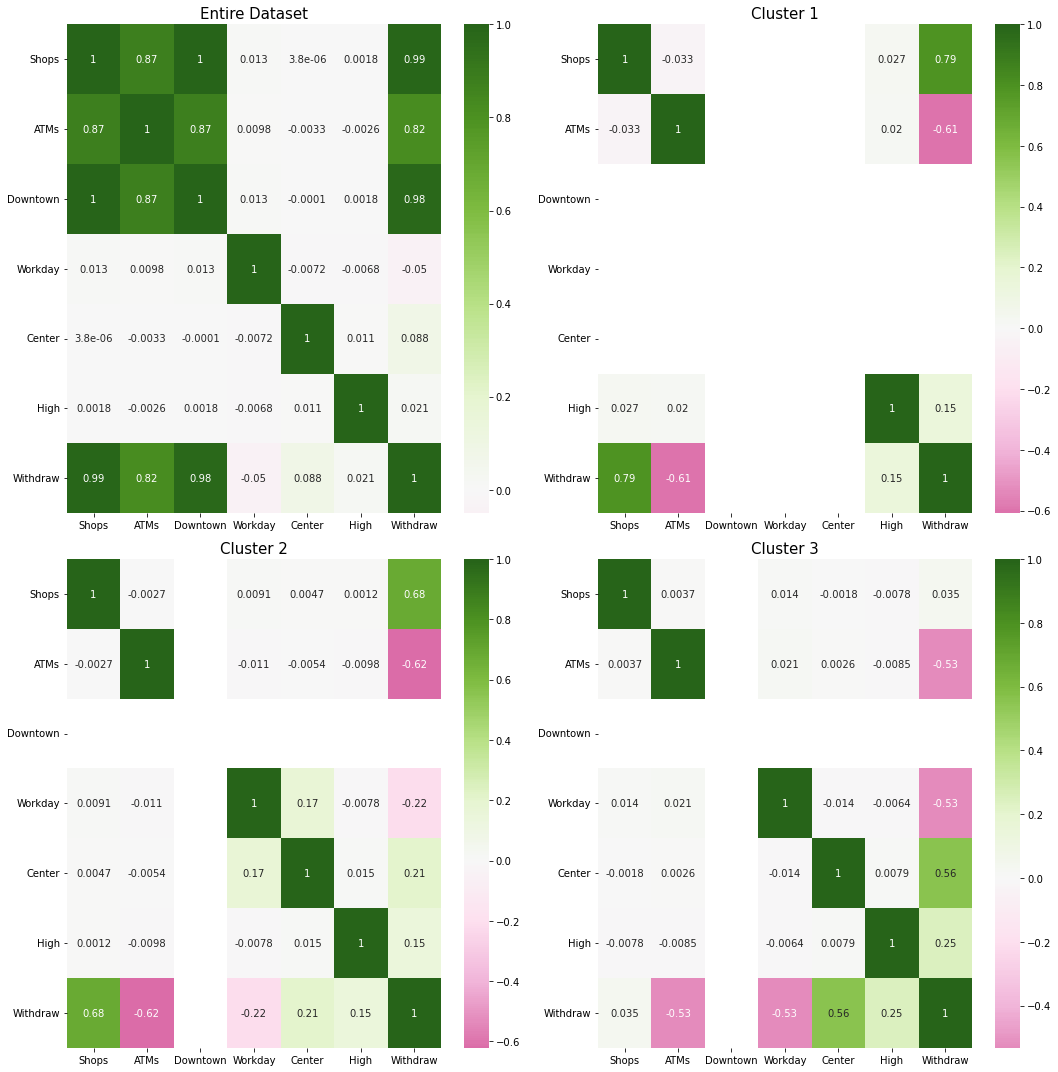

In [543]:
plt.figure(figsize=(15, 15))

# Subplot 1: Entire Dataset
plt.subplot(2, 2, 1)
sns.heatmap(df.corr(),  cmap='PiYG', center=0, annot=True)
plt.title('Entire Dataset', fontsize=15)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Subplot 2: Cluster 1
plt.subplot(2, 2, 2)
sns.heatmap(cluster1.corr(),  cmap='PiYG', center=0, annot=True)
plt.title('Cluster 1', fontsize=15)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Subplot 3: Cluster 2
plt.subplot(2, 2, 3)
sns.heatmap(cluster2.corr(),  cmap='PiYG', center=0, annot=True)
plt.title('Cluster 2', fontsize=15)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Subplot 4: Cluster 3
plt.subplot(2, 2, 4)
sns.heatmap(cluster3.corr(),  cmap='PiYG', center=0, annot=True)
plt.title('Cluster 3', fontsize=15)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

<center>
 <h2>Model Training</h2>
<center>

### 1.1 Cluster 1 Base Model

In [544]:
# Cluster 1: "Downtown AND Holiday AND Center"
cluster1 = df[(df.Downtown == 1) & (df.Workday == 0) & (df.Center == 1)]

# Drop irrelevant columns
cluster1 = cluster1.drop(['Downtown', 'Workday', 'Center'], axis = 1)
cluster1.reset_index(drop = True, inplace=True)

# Define response variable inputs
y1 = cluster1['Withdraw']

# Define predictor inputs
X1 = cluster1.drop('Withdraw', axis = 1)

# Split data into train and test set
train_cluster1 = cluster1.sample(frac=0.8, random_state = 42)
test_cluster1 = cluster1[cluster1.index.isin(train_cluster1.index)==False]

# Get the indices for train and test sets
train_cluster1_indices = train_cluster1.index
test_cluster1_indices = test_cluster1.index

# Find best features using best subset selection
best_features_cluster1 = best_subset_selection(X1, train_cluster1, test_cluster1)
best_model_cluster1 = ols(best_features_cluster1, data=train_cluster1).fit()

# Get formula and features
formula_cluster1 = get_formula(best_model_cluster1)
cluster1_features = get_features(best_model_cluster1)

# Print Formula, CV Test MSEs
print("-" * 110)
print("Best Base Model Cluster1: \n" + formula_cluster1)
print("-" * 110)
cv_cluster1 = cross_validation_mse(cluster1, cluster1_features)
print("-" * 110)
print(f"Average CV Test MSE: {cv_cluster1:.4f}")

--------------------------------------------------------------------------------------------------------------
Best Base Model Cluster1: 
Withdraw = -28.3978 + (0.1324*Shops) + (-1.0044*ATMs) + (1.0594*High)
--------------------------------------------------------------------------------------------------------------
CV Test MSE Fold 1: 0.2167
CV Test MSE Fold 2: 0.2152
CV Test MSE Fold 3: 0.2270
CV Test MSE Fold 4: 0.2262
CV Test MSE Fold 5: 0.1839
--------------------------------------------------------------------------------------------------------------
Average CV Test MSE: 0.2138


### 1.2 Cluster 2 Base Model

In [545]:
# Cluster 2: downtown and holiday and not center OR downtown and weekday
cluster2 = df[(df.Downtown == 1) & (((df.Workday == 0) & (df.Center == 0)) | (df.Workday == 1))]

# Drop irrelevant columns
cluster2 = cluster2.drop(['Downtown'], axis = 1)
cluster2.reset_index(drop = True, inplace=True)

# Define response variable inputs
y2 = cluster2['Withdraw']

# Define predictor inputs
X2 = cluster2.drop('Withdraw', axis = 1)

# Split data into train and test set
train_cluster2 = cluster2.sample(frac=0.8)
test_cluster2 = cluster2[cluster2.index.isin(train_cluster2.index)==False]

# Get the indices for train and test sets
train_cluster2_indices = train_cluster2.index
test_cluster2_indices = test_cluster2.index

# Find best features using best subset selection
best_features_cluster2 = best_subset_selection(X2, train_cluster2, test_cluster2)
best_model_cluster2 = ols(best_features_cluster2, data=train_cluster2).fit()

# Get formula and features
formula_cluster2 = get_formula(best_model_cluster2)
cluster2_features = get_features(best_model_cluster2)

# Print Formula, CV Test MSEs
print("-" * 110)
print("Best Base Model Cluster2: \n" + formula_cluster2)
print("-" * 110)
cv_cluster2 = cross_validation_mse(cluster2, cluster2_features)
print("-" * 110)
print(f"Average CV Test MSE: {cv_cluster2:.4f}")

--------------------------------------------------------------------------------------------------------------
Best Base Model Cluster2: 
Withdraw = -28.9774 + (0.1100*Shops) + (-1.0001*ATMs) + (-1.9939*Workday) + (3.0040*Center) + (0.9947*High)
--------------------------------------------------------------------------------------------------------------
CV Test MSE Fold 1: 0.2396
CV Test MSE Fold 2: 0.2517
CV Test MSE Fold 3: 0.2453
CV Test MSE Fold 4: 0.2509
CV Test MSE Fold 5: 0.2561
--------------------------------------------------------------------------------------------------------------
Average CV Test MSE: 0.2487


### 1.3 Cluster 3 Base Model

In [546]:
# Cluster 3: not downtown
cluster3 = df[(df.Downtown == 0)]

# Drop irrelevant columns
cluster3 = cluster3.drop(['Downtown'], axis = 1)
cluster3.reset_index(drop = True, inplace=True)

# Define response variable inputs
y3 = cluster3['Withdraw']

# Define predictor inputs
X3 = cluster3.drop('Withdraw', axis = 1)

# Split data into train and test set
train_cluster3 = cluster3.sample(frac=0.8, random_state = 42)
test_cluster3 = cluster3[cluster3.index.isin(train_cluster3.index)==False]

# Get the indices for train and test sets
train_cluster3_indices = train_cluster3.index
test_cluster3_indices = test_cluster3.index

# Find best features using best subset selection
best_features_cluster3 = best_subset_selection(X3, train_cluster3, test_cluster3)
best_model_cluster3 = ols(best_features_cluster3, data=train_cluster3).fit()

# Get formula and features
formula_cluster3 = get_formula(best_model_cluster3)
cluster3_features = get_features(best_model_cluster3)

# Print Formula, CV Test MSEs
print("-" * 110)
print("Best Base Model Cluster3: \n" + formula_cluster3)
print("-" * 110)
cv_cluster3 = cross_validation_mse(cluster3, cluster3_features)
print("-" * 110)
print(f"Average CV Test MSE: {cv_cluster3:.4f}")

--------------------------------------------------------------------------------------------------------------
Best Base Model Cluster3: 
Withdraw = 18.8333 + (0.0184*Shops) + (-0.9974*ATMs) + (-2.2464*Workday) + (3.6229*Center) + (1.0279*High)
--------------------------------------------------------------------------------------------------------------
CV Test MSE Fold 1: 0.3394
CV Test MSE Fold 2: 0.3509
CV Test MSE Fold 3: 0.3222
CV Test MSE Fold 4: 0.3210
CV Test MSE Fold 5: 0.3060
--------------------------------------------------------------------------------------------------------------
Average CV Test MSE: 0.3279


### 2.1 Cluster 1 Enhanced Model

In [547]:
# Cluster 1 Enhanced: adding interaction terms and polynomial terms to degree 3 
cluster1 = df[(df.Downtown == 1) & (df.Workday == 0) & (df.Center == 1)]

# Drop irrelevant columns
cluster1 = cluster1.drop(['Downtown', 'Workday', 'Center'], axis = 1)
cluster1.reset_index(drop = True, inplace=True)
cluster1_enhanced = cluster1.copy()

# Polynomial terms for Shops and ATMs
cluster1_enhanced['ShopsSquared'] = cluster1['Shops'] ** 2
cluster1_enhanced['ShopsCubed'] = cluster1['Shops'] ** 3
cluster1_enhanced['ATMsSquared'] = cluster1['ATMs'] ** 2
cluster1_enhanced['ATMsCubed'] = cluster1['ATMs'] ** 3

# Log transformations for Shops and ATMs
cluster1_enhanced['log_Shops'] = np.log(cluster1['Shops'])
cluster1_enhanced['log_ATMs'] = np.log(cluster1['ATMs'])

# Two term interactions
cluster1_enhanced['Shops_ATMs'] = cluster1['Shops'] * cluster1['ATMs']
cluster1_enhanced['Shops_High'] = cluster1['Shops'] * cluster1['High']
cluster1_enhanced['Shops_ATMsSquared'] = cluster1['Shops'] * cluster1_enhanced['ATMsSquared']
cluster1_enhanced['Shops_ATMsCubed'] = cluster1['Shops'] * cluster1_enhanced['ATMsCubed']
cluster1_enhanced['Shops_log_Shops'] = cluster1['Shops'] * np.log(cluster1['Shops'])
cluster1_enhanced['Shops_log_ATMs'] = cluster1['Shops'] * np.log(cluster1['ATMs'])

cluster1_enhanced['ATMs_High'] = cluster1['ATMs'] * cluster1['High']
cluster1_enhanced['ATMs_ShopsSquared'] = cluster1['ATMs'] * cluster1_enhanced['ShopsSquared']
cluster1_enhanced['ATMs_ShopsCubed'] = cluster1['ATMs'] * cluster1_enhanced['ShopsCubed']
cluster1_enhanced['ATMs_log_Shops'] = cluster1['ATMs'] * np.log(cluster1['Shops'])
cluster1_enhanced['ATMs_log_ATMs'] = cluster1['ATMs'] * np.log(cluster1['ATMs'])

cluster1_enhanced['High_ShopsSquared'] = cluster1['High'] * cluster1_enhanced['ShopsSquared']
cluster1_enhanced['High_ShopsCubed'] = cluster1['High'] * cluster1_enhanced['ShopsCubed']
cluster1_enhanced['High_ATMsSquared'] = cluster1['High'] * cluster1_enhanced['ATMsSquared']
cluster1_enhanced['High_ATMsCubed'] = cluster1['High'] * cluster1_enhanced['ATMsCubed']
cluster1_enhanced['High_log_Shops'] = cluster1['High'] * np.log(cluster1['Shops'])
cluster1_enhanced['High_log_ATMs'] = cluster1['High'] * np.log(cluster1['ATMs'])

cluster1_enhanced['ShopsSquared_ATMsSquared'] = cluster1_enhanced['ShopsSquared'] * cluster1_enhanced['ATMsSquared']
cluster1_enhanced['ShopsSquared_ATMsCubed'] = cluster1_enhanced['ShopsSquared'] * cluster1_enhanced['ATMsCubed']
cluster1_enhanced['ShopsSquared_log_Shops'] = cluster1_enhanced['ShopsSquared'] * np.log(cluster1['Shops'])
cluster1_enhanced['ShopsSquared_log_ATMs'] = cluster1_enhanced['ShopsSquared'] * np.log(cluster1['ATMs'])
cluster1_enhanced['ShopsSquared_log_Shops'] = cluster1_enhanced['ShopsSquared'] * np.log(cluster1['Shops'])
cluster1_enhanced['ShopsSquared_log_ATMs'] = cluster1_enhanced['ShopsSquared'] * np.log(cluster1['ATMs'])

cluster1_enhanced['ATMsSquared_ShopsCubed'] = cluster1_enhanced['ATMsSquared'] * cluster1_enhanced['ShopsCubed']
cluster1_enhanced['ATMsSquared_log_Shops'] = cluster1_enhanced['ATMsSquared'] * np.log(cluster1['Shops'])
cluster1_enhanced['ATMsSquared_log_ATMs'] = cluster1_enhanced['ATMsSquared'] * np.log(cluster1['ATMs'])
cluster1_enhanced['ATMsSquared_log_Shops'] = cluster1_enhanced['ATMsSquared'] * np.log(cluster1['Shops'])
cluster1_enhanced['ATMsSquared_log_ATMs'] = cluster1_enhanced['ATMsSquared'] * np.log(cluster1['ATMs'])

cluster1_enhanced['ShopsCubed_ATMsCubed'] = cluster1_enhanced['ShopsCubed'] * cluster1_enhanced['ATMsCubed']
cluster1_enhanced['ShopsCubed_log_Shops'] = cluster1_enhanced['ShopsCubed'] * np.log(cluster1['Shops'])
cluster1_enhanced['ShopsCubed_log_ATMs'] = cluster1_enhanced['ShopsCubed'] * np.log(cluster1['ATMs'])

cluster1_enhanced['ATMsCubed_log_Shops'] = cluster1_enhanced['ATMsCubed'] * np.log(cluster1['Shops'])
cluster1_enhanced['ATMsCubed_log_ATMs'] = cluster1_enhanced['ATMsCubed'] * np.log(cluster1['ATMs'])

cluster1_enhanced['log_Shops_log_ATMs'] = np.log(cluster1['Shops']) * np.log(cluster1['ATMs'])

# Define response variable inputs
y1_e = cluster1_enhanced['Withdraw']

# Define predictor inputs
X1_e = cluster1_enhanced.drop('Withdraw', axis = 1)

# Split the enhanced dataset using the same indices
train_cluster1_enhanced = cluster1_enhanced.loc[train_cluster1_indices]
test_cluster1_enhanced = cluster1_enhanced.loc[test_cluster1_indices]

# Verify train-test split consistency
assert train_cluster1.index.equals(train_cluster1_enhanced.index)
assert test_cluster1.index.equals(test_cluster1_enhanced.index)

# Find best features using forward selection
best_features_cluster1_enhanced = forward_selection(X1_e, train_cluster1_enhanced, test_cluster1_enhanced)
best_model_cluster1_enhanced = ols(best_features_cluster1_enhanced, data=train_cluster1_enhanced).fit()

# Get formula and features
formula_cluster1_enhanced = get_formula(best_model_cluster1_enhanced)
cluster1_features_enhanced = get_features(best_model_cluster1_enhanced)

# Print Formula, CV Test MSEs
print("-" * 110)
print("Best Enhanced Model Cluster1: \n" + formula_cluster1_enhanced)
print("-" * 110)
cv_cluster1_enhanced = cross_validation_mse(cluster1_enhanced, cluster1_features_enhanced)
print("-" * 110)
print(f"Average CV Test MSE: {cv_cluster1_enhanced:.4f}")

--------------------------------------------------------------------------------------------------------------
Best Enhanced Model Cluster1: 
Withdraw = -807.3046 + (131.9334*log_Shops) + (-1.0051*ATMs) + (1.0612*High)
--------------------------------------------------------------------------------------------------------------
CV Test MSE Fold 1: 0.2269
CV Test MSE Fold 2: 0.2181
CV Test MSE Fold 3: 0.2376
CV Test MSE Fold 4: 0.2282
CV Test MSE Fold 5: 0.1837
--------------------------------------------------------------------------------------------------------------
Average CV Test MSE: 0.2189


### 2.2 Cluster 2 Enhanced Model

In [458]:
# Cluster 2: downtown and holiday and not center OR downtown and weekday
cluster2 = df[(df.Downtown == 1) & (((df.Workday == 0) & (df.Center == 0)) | (df.Workday == 1))]

# Drop irrelevant columns
cluster2 = cluster2.drop(['Downtown'], axis = 1)
cluster2.reset_index(drop = True, inplace=True)

cluster2_enhanced = cluster2.copy()

# Polynomial terms for Shops and ATMs
cluster2_enhanced['ShopsSquared'] = cluster2['Shops'] ** 2
cluster2_enhanced['ShopsCubed'] = cluster2['Shops'] ** 3
cluster2_enhanced['ATMsSquared'] = cluster2['ATMs'] ** 2
cluster2_enhanced['ATMsCubed'] = cluster2['ATMs'] ** 3

# Log transformations for Shops and ATMs
cluster2_enhanced['log_Shops'] = np.log(cluster2['Shops'] + epsilon)
cluster2_enhanced['log_ATMs'] = np.log(cluster2['ATMs'] + epsilon)

# Two-term interactions
cluster2_enhanced['Shops_ATMs'] = cluster2['Shops'] * cluster2['ATMs']
cluster2_enhanced['Shops_High'] = cluster2['Shops'] * cluster2['High']
cluster2_enhanced['Shops_Center'] = cluster2['Shops'] * cluster2['Center']
cluster2_enhanced['Shops_Workday'] = cluster2['Shops'] * cluster2['Workday']
cluster2_enhanced['Shops_ATMsSquared'] = cluster2['Shops'] * cluster2_enhanced['ATMsSquared']
cluster2_enhanced['Shops_ATMsCubed'] = cluster2['Shops'] * cluster2_enhanced['ATMsCubed']
cluster2_enhanced['Shops_log_Shops'] = cluster2['Shops'] * np.log(cluster2['Shops'] + epsilon)
cluster2_enhanced['Shops_log_ATMs'] = cluster2['Shops'] * np.log(cluster2['ATMs'] + epsilon)

cluster2_enhanced['ATMs_High'] = cluster2['ATMs'] * cluster2['High']
cluster2_enhanced['ATMs_Center'] = cluster2['ATMs'] * cluster2['Center']
cluster2_enhanced['ATMs_Workday'] = cluster2['ATMs'] * cluster2['Workday']
cluster2_enhanced['ATMs_ShopsSquared'] = cluster2['ATMs'] * cluster2_enhanced['ShopsSquared']
cluster2_enhanced['ATMs_ShopsCubed'] = cluster2['ATMs'] * cluster2_enhanced['ShopsCubed']
cluster2_enhanced['ATMs_log_Shops'] = cluster2['ATMs'] * np.log(cluster2['Shops'] + epsilon)
cluster2_enhanced['ATMs_log_ATMs'] = cluster2['ATMs'] * np.log(cluster2['ATMs'] + epsilon)

cluster2_enhanced['High_Center'] = cluster2['High'] * cluster2['Center']
cluster2_enhanced['High_Workday'] = cluster2['High'] * cluster2['Workday']
cluster2_enhanced['High_ShopsSquared'] = cluster2['High'] * cluster2_enhanced['ShopsSquared']
cluster2_enhanced['High_ShopsCubed'] = cluster2['High'] * cluster2_enhanced['ShopsCubed']
cluster2_enhanced['High_ATMsSquared'] = cluster2['High'] * cluster2_enhanced['ATMsSquared']
cluster2_enhanced['High_ATMsCubed'] = cluster2['High'] * cluster2_enhanced['ATMsCubed']
cluster2_enhanced['High_log_Shops'] = cluster2['High'] * np.log(cluster2['Shops'] + epsilon)
cluster2_enhanced['High_log_ATMs'] = cluster2['High'] * np.log(cluster2['ATMs'] + epsilon)

cluster2_enhanced['Workday_Center'] = cluster2['Workday'] * cluster2['Center']
cluster2_enhanced['Workday_ShopsSquared'] = cluster2['Workday'] * cluster2_enhanced['ShopsSquared']
cluster2_enhanced['Workday_ShopsCubed'] = cluster2['Workday'] * cluster2_enhanced['ShopsCubed']
cluster2_enhanced['Workday_ATMsSquared'] = cluster2['Workday'] * cluster2_enhanced['ATMsSquared']
cluster2_enhanced['Workday_ATMsCubed'] = cluster2['Workday'] * cluster2_enhanced['ATMsCubed']
cluster2_enhanced['Workday_log_Shops'] = cluster2['Workday'] * np.log(cluster2['Shops'] + epsilon)
cluster2_enhanced['Workday_log_ATMs'] = cluster2['Workday'] * np.log(cluster2['ATMs'] + epsilon)

cluster2_enhanced['Center_ShopsSquared'] = cluster2['Center'] * cluster2_enhanced['ShopsSquared']
cluster2_enhanced['Center_ShopsCubed'] = cluster2['Center'] * cluster2_enhanced['ShopsCubed']
cluster2_enhanced['Center_ATMsSquared'] = cluster2['Center'] * cluster2_enhanced['ATMsSquared']
cluster2_enhanced['Center_ATMsCubed'] = cluster2['Center'] * cluster2_enhanced['ATMsCubed']
cluster2_enhanced['Center_log_Shops'] = cluster2['Center'] * np.log(cluster2['Shops'] + epsilon)
cluster2_enhanced['Center_log_ATMs'] = cluster2['Center'] * np.log(cluster2['ATMs'] + epsilon)

cluster2_enhanced['ShopsSquared_ATMsSquared'] = cluster2_enhanced['ShopsSquared'] * cluster2_enhanced['ATMsSquared']
cluster2_enhanced['ShopsSquared_ATMsCubed'] = cluster2_enhanced['ShopsSquared'] * cluster2_enhanced['ATMsCubed']
cluster2_enhanced['ShopsSquared_log_Shops'] = cluster2_enhanced['ShopsSquared'] * np.log(cluster2['Shops'] + epsilon)
cluster2_enhanced['ShopsSquared_log_ATMs'] = cluster2_enhanced['ShopsSquared'] * np.log(cluster2['ATMs'] + epsilon)

cluster2_enhanced['ATMsSquared_ShopsCubed'] = cluster2_enhanced['ATMsSquared'] * cluster2_enhanced['ShopsCubed']
cluster2_enhanced['ATMsSquared_log_Shops'] = cluster2_enhanced['ATMsSquared'] * np.log(cluster2['Shops'] + epsilon)
cluster2_enhanced['ATMsSquared_log_ATMs'] = cluster2_enhanced['ATMsSquared'] * np.log(cluster2['ATMs'] + epsilon)

cluster2_enhanced['ShopsCubed_ATMsCubed'] = cluster2_enhanced['ShopsCubed'] * cluster2_enhanced['ATMsCubed']
cluster2_enhanced['ShopsCubed_log_Shops'] = cluster2_enhanced['ShopsCubed'] * np.log(cluster2['Shops'] + epsilon)
cluster2_enhanced['ShopsCubed_log_ATMs'] = cluster2_enhanced['ShopsCubed'] * np.log(cluster2['ATMs'] + epsilon)

cluster2_enhanced['ATMsCubed_log_Shops'] = cluster2_enhanced['ATMsCubed'] * np.log(cluster2['Shops'] + epsilon)
cluster2_enhanced['ATMsCubed_log_ATMs'] = cluster2_enhanced['ATMsCubed'] * np.log(cluster2['ATMs'] + epsilon)

cluster2_enhanced['log_Shops_log_ATMs'] = np.log(cluster2['Shops'] + epsilon) * np.log(cluster2['ATMs'] + epsilon)

# Define response variable inputs
y2_e = cluster2_enhanced['Withdraw']

# Define predictor inputs
X2_e = cluster2_enhanced.drop('Withdraw', axis = 1)

# Split the enhanced dataset using the same indices
train_cluster2_enhanced = cluster2_enhanced.loc[train_cluster2_indices]
test_cluster2_enhanced = cluster2_enhanced.loc[test_cluster2_indices]

# Verify train-test split consistency
assert train_cluster2.index.equals(train_cluster2_enhanced.index)
assert test_cluster2.index.equals(test_cluster2_enhanced.index)

# Find best features using forward selection
best_features_cluster2_enhanced = forward_selection(X2_e, train_cluster2_enhanced, test_cluster2_enhanced)
best_model_cluster2_enhanced = ols(best_features_cluster2_enhanced, data=train_cluster2_enhanced).fit()

# Get formula and features
formula_cluster2_enhanced = get_formula(best_model_cluster2_enhanced)
cluster2_features_enhanced = get_features(best_model_cluster2_enhanced)

# Print Formula, CV Test MSEs
print("-" * 110)
print("Best Enhanced Model Cluster2: \n" + formula_cluster2_enhanced)
print("-" * 110)
cv_cluster2_enhanced = cross_validation_mse(cluster2_enhanced, cluster2_features_enhanced)
print("-" * 110)
print(f"Average CV Test MSE: {cv_cluster2_enhanced:.4f}")

--------------------------------------------------------------------------------------------------------------
Best Enhanced Model Cluster2: 
Withdraw = -0.2082 + (-5.2153*log_Shops) + (-2.9531*ATMs_log_Shops) + (-2.3398*Workday) + (-0.1439*Center_log_Shops) + (0.0010*Shops_High) + (0.1174*Shops) + (-0.7969*Center_log_ATMs) + (0.1851*Workday_log_ATMs) + (0.0754*ATMs_Center) + (-0.0006*Workday_ATMsSquared) + (2.5241*Center) + (0.0000*ShopsSquared_ATMsCubed) + (0.0000*ATMs_ShopsCubed) + (18.4932*ATMs) + (-0.0001*ATMsCubed_log_ATMs) + (-0.0056*High_log_Shops) + (2.5241*Workday_Center) + (0.0001*Center_ATMsSquared)
--------------------------------------------------------------------------------------------------------------
CV Test MSE Fold 1: 0.2388
CV Test MSE Fold 2: 0.2512
CV Test MSE Fold 3: 0.2460
CV Test MSE Fold 4: 0.2492
CV Test MSE Fold 5: 0.2549
--------------------------------------------------------------------------------------------------------------
Average CV Test MSE: 0.2

### 2.3 Cluster 3 Enhanced Model

In [460]:
# Cluster 3: not downtown
cluster3 = df[(df.Downtown == 0)]

# Drop irrelevant columns
cluster3 = cluster3.drop(['Downtown'], axis = 1)
cluster3.reset_index(drop = True, inplace=True)

cluster3_enhanced = cluster3.copy()

# Polynomial terms for Shops and ATMs
cluster3_enhanced['ShopsSquared'] = cluster3['Shops'] ** 2
cluster3_enhanced['ShopsCubed'] = cluster3['Shops'] ** 3
cluster3_enhanced['ATMsSquared'] = cluster3['ATMs'] ** 2
cluster3_enhanced['ATMsCubed'] = cluster3['ATMs'] ** 3

# Log transformations for Shops and ATMs
cluster3_enhanced['log_Shops'] = np.log(cluster3['Shops'] + epsilon)
cluster3_enhanced['log_ATMs'] = np.log(cluster3['ATMs'] + epsilon)

# Two-term interactions
cluster3_enhanced['Shops_ATMs'] = cluster3['Shops'] * cluster3['ATMs']
cluster3_enhanced['Shops_High'] = cluster3['Shops'] * cluster3['High']
cluster3_enhanced['Shops_Center'] = cluster3['Shops'] * cluster3['Center']
cluster3_enhanced['Shops_Workday'] = cluster3['Shops'] * cluster3['Workday']
cluster3_enhanced['Shops_ATMsSquared'] = cluster3['Shops'] * cluster3_enhanced['ATMsSquared']
cluster3_enhanced['Shops_ATMsCubed'] = cluster3['Shops'] * cluster3_enhanced['ATMsCubed']
cluster3_enhanced['Shops_log_Shops'] = cluster3['Shops'] * np.log(cluster3['Shops'] + epsilon)
cluster3_enhanced['Shops_log_ATMs'] = cluster3['Shops'] * np.log(cluster3['ATMs'] + epsilon)

cluster3_enhanced['ATMs_High'] = cluster3['ATMs'] * cluster3['High']
cluster3_enhanced['ATMs_Center'] = cluster3['ATMs'] * cluster3['Center']
cluster3_enhanced['ATMs_Workday'] = cluster3['ATMs'] * cluster3['Workday']
cluster3_enhanced['ATMs_ShopsSquared'] = cluster3['ATMs'] * cluster3_enhanced['ShopsSquared']
cluster3_enhanced['ATMs_ShopsCubed'] = cluster3['ATMs'] * cluster3_enhanced['ShopsCubed']
cluster3_enhanced['ATMs_log_Shops'] = cluster3['ATMs'] * np.log(cluster3['Shops'] + epsilon)
cluster3_enhanced['ATMs_log_ATMs'] = cluster3['ATMs'] * np.log(cluster3['ATMs'] + epsilon)

cluster3_enhanced['High_Center'] = cluster3['High'] * cluster3['Center']
cluster3_enhanced['High_Workday'] = cluster3['High'] * cluster3['Workday']
cluster3_enhanced['High_ShopsSquared'] = cluster3['High'] * cluster3_enhanced['ShopsSquared']
cluster3_enhanced['High_ShopsCubed'] = cluster3['High'] * cluster3_enhanced['ShopsCubed']
cluster3_enhanced['High_ATMsSquared'] = cluster3['High'] * cluster3_enhanced['ATMsSquared']
cluster3_enhanced['High_ATMsCubed'] = cluster3['High'] * cluster3_enhanced['ATMsCubed']
cluster3_enhanced['High_log_Shops'] = cluster3['High'] * np.log(cluster3['Shops'] + epsilon)
cluster3_enhanced['High_log_ATMs'] = cluster3['High'] * np.log(cluster3['ATMs'] + epsilon)

cluster3_enhanced['Workday_Center'] = cluster3['Workday'] * cluster3['Center']
cluster3_enhanced['Workday_ShopsSquared'] = cluster3['Workday'] * cluster3_enhanced['ShopsSquared']
cluster3_enhanced['Workday_ShopsCubed'] = cluster3['Workday'] * cluster3_enhanced['ShopsCubed']
cluster3_enhanced['Workday_ATMsSquared'] = cluster3['Workday'] * cluster3_enhanced['ATMsSquared']
cluster3_enhanced['Workday_ATMsCubed'] = cluster3['Workday'] * cluster3_enhanced['ATMsCubed']
cluster3_enhanced['Workday_log_Shops'] = cluster3['Workday'] * np.log(cluster3['Shops'] + epsilon)
cluster3_enhanced['Workday_log_ATMs'] = cluster3['Workday'] * np.log(cluster3['ATMs'] + epsilon)

cluster3_enhanced['Center_ShopsSquared'] = cluster3['Center'] * cluster3_enhanced['ShopsSquared']
cluster3_enhanced['Center_ShopsCubed'] = cluster3['Center'] * cluster3_enhanced['ShopsCubed']
cluster3_enhanced['Center_ATMsSquared'] = cluster3['Center'] * cluster3_enhanced['ATMsSquared']
cluster3_enhanced['Center_ATMsCubed'] = cluster3['Center'] * cluster3_enhanced['ATMsCubed']
cluster3_enhanced['Center_log_Shops'] = cluster3['Center'] * np.log(cluster3['Shops'] + epsilon)
cluster3_enhanced['Center_log_ATMs'] = cluster3['Center'] * np.log(cluster3['ATMs'] + epsilon)

cluster3_enhanced['ShopsSquared_ATMsSquared'] = cluster3_enhanced['ShopsSquared'] * cluster3_enhanced['ATMsSquared']
cluster3_enhanced['ShopsSquared_ATMsCubed'] = cluster3_enhanced['ShopsSquared'] * cluster3_enhanced['ATMsCubed']
cluster3_enhanced['ShopsSquared_log_Shops'] = cluster3_enhanced['ShopsSquared'] * np.log(cluster3['Shops'] + epsilon)
cluster3_enhanced['ShopsSquared_log_ATMs'] = cluster3_enhanced['ShopsSquared'] * np.log(cluster3['ATMs'] + epsilon)

cluster3_enhanced['ATMsSquared_ShopsCubed'] = cluster3_enhanced['ATMsSquared'] * cluster3_enhanced['ShopsCubed']
cluster3_enhanced['ATMsSquared_log_Shops'] = cluster3_enhanced['ATMsSquared'] * np.log(cluster3['Shops'] + epsilon)
cluster3_enhanced['ATMsSquared_log_ATMs'] = cluster3_enhanced['ATMsSquared'] * np.log(cluster3['ATMs'] + epsilon)

cluster3_enhanced['ShopsCubed_ATMsCubed'] = cluster3_enhanced['ShopsCubed'] * cluster3_enhanced['ATMsCubed']
cluster3_enhanced['ShopsCubed_log_Shops'] = cluster3_enhanced['ShopsCubed'] * np.log(cluster3['Shops'] + epsilon)
cluster3_enhanced['ShopsCubed_log_ATMs'] = cluster3_enhanced['ShopsCubed'] * np.log(cluster3['ATMs'] + epsilon)

cluster3_enhanced['ATMsCubed_log_Shops'] = cluster3_enhanced['ATMsCubed'] * np.log(cluster3['Shops'] + epsilon)
cluster3_enhanced['ATMsCubed_log_ATMs'] = cluster3_enhanced['ATMsCubed'] * np.log(cluster3['ATMs'] + epsilon)

cluster3_enhanced['log_Shops_log_ATMs'] = np.log(cluster3['Shops'] + epsilon) * np.log(cluster3['ATMs'] + epsilon)

# Define response variable inputs
y3_e = cluster3_enhanced['Withdraw']

# Define predictor inputs
X3_e = cluster3_enhanced.drop('Withdraw', axis = 1)

# Split the enhanced dataset using the same indices
train_cluster3_enhanced = cluster3_enhanced.loc[train_cluster3_indices]
test_cluster3_enhanced = cluster3_enhanced.loc[test_cluster3_indices]

# Verify train-test split consistency
assert train_cluster3.index.equals(train_cluster3_enhanced.index)
assert test_cluster3.index.equals(test_cluster3_enhanced.index)

# Find best features using forward selection
best_features_cluster3_enhanced = forward_selection(X3_e, train_cluster3_enhanced, test_cluster3_enhanced)
best_model_cluster3_enhanced = ols(best_features_cluster3_enhanced, data=train_cluster3_enhanced).fit()

# Get formula and features
formula_cluster3_enhanced = get_formula(best_model_cluster3_enhanced)
cluster3_features_enhanced = get_features(best_model_cluster3_enhanced)

# Print Formula, CV Test MSEs
print("-" * 110)
print("Best Enhanced Model Cluster3: \n" + formula_cluster3_enhanced)
print("-" * 110)
cv_cluster3_enhanced = cross_validation_mse(cluster3_enhanced, cluster3_features_enhanced)
print("-" * 110)
print(f"Average CV Test MSE: {cv_cluster3_enhanced:.4f}")

--------------------------------------------------------------------------------------------------------------
Best Enhanced Model Cluster3: 
Withdraw = 10.1613 + (0.0115*ATMs_Workday) + (18.8237*Center) + (-0.8059*ATMs) + (0.0005*High_ShopsSquared) + (8.9761*Workday) + (-1.9630*Workday_Center) + (2.2564*log_Shops) + (-0.0000*High_ShopsCubed) + (0.0057*High_log_ATMs) + (-0.0264*High_Center) + (-2.5580*Workday_log_Shops) + (0.0000*Workday_ShopsCubed) + (-0.5689*High) + (0.0000*Center_ShopsCubed) + (-3.2607*Center_log_Shops) + (-0.0442*ATMs_log_Shops) + (0.0026*ATMs_Center)
--------------------------------------------------------------------------------------------------------------
CV Test MSE Fold 1: 0.2557
CV Test MSE Fold 2: 0.2618
CV Test MSE Fold 3: 0.2464
CV Test MSE Fold 4: 0.2510
CV Test MSE Fold 5: 0.2473
--------------------------------------------------------------------------------------------------------------
Average CV Test MSE: 0.2524


<center>
 <h2>Model Summaries</h2>
<center>

In [564]:
print("==================================================================")
print('                Best Base Model Cluster 1 Summary')
print(best_model_cluster1.summary2())
print("==================================================================")
print('                Best Base Model Cluster 2 Summary')
print(best_model_cluster2.summary2())
print("==================================================================")
print('                Best Base Model Cluster 3 Summary')
print(best_model_cluster3.summary2())
print("====================================================================")
print('                Best Enhanced Model Cluster 1 Summary')
print(best_model_cluster1_enhanced.summary2())
print("====================================================================")
print('                Best Enhanced Model Cluster 2 Summary')
print(best_model_cluster2_enhanced.summary2())
print("====================================================================")
print('                Best Enhanced Model Cluster 3 Summary')
print(best_model_cluster3_enhanced.summary2())

                Best Base Model Cluster 1 Summary
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.983    
Dependent Variable: Withdraw         AIC:                478.1824 
Date:               2024-11-09 19:50 BIC:                493.7710 
No. Observations:   364              Log-Likelihood:     -235.09  
Df Model:           3                F-statistic:        6884.    
Df Residuals:       360              Prob (F-statistic): 1.87e-317
R-squared:          0.983            Scale:              0.21543  
-------------------------------------------------------------------
            Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept  -28.3978    1.1959  -23.7458  0.0000  -30.7497  -26.0460
Shops        0.1324    0.0012  111.8871  0.0000    0.1301    0.1348
ATMs        -1.0044    0.0125  -80.3681  0.0000   -1.0290   -0.9798
High         1.0594    0

<center>
 <h2>Overall Model Evaluation</h2>
<center>

In [563]:
# Print all model's CV MSE
print("-" * 110)
print(f"Best Base Model Cluster1 CV Test MSE: {cv_cluster1:.4f}")
print(f"Best Base Model Cluster2 CV Test MSE: {cv_cluster2:.4f}")
print(f"Best Base Model Cluster3 CV Test MSE: {cv_cluster3:.4f}")
print("-" * 110)
print(f"Best Enhanced Model Cluster1 CV Test MSE: {cv_cluster1_enhanced:.4f}")
print(f"Best Enhanced Model Cluster2 CV Test MSE: {cv_cluster2_enhanced:.4f}")
print(f"Best Enhanced Model Cluster3 CV Test MSE: {cv_cluster3_enhanced:.4f}")
print("-" * 110)

# Calculate Weights of Each Cluster
weight1 = len(cluster1) / len(df)
weight2 = len(cluster2) / len(df)
weight3 = len(cluster3) / len(df)

print('Final Model')
print('Cluster1: Base Model')
print('Cluster2: Enhanced Model')
print('Cluster3: Enhanced Model')
print("-" * 110)

weighted_average_cv = (weight1 * min(cv_cluster1, cv_cluster1_enhanced) + weight2 * min(cv_cluster2, cv_cluster2_enhanced) + weight3 * min(cv_cluster3, cv_cluster3_enhanced))
average_cv = (1/3 * min(cv_cluster1, cv_cluster1_enhanced) + 1/3 * min(cv_cluster2, cv_cluster2_enhanced) + 1/3 * min(cv_cluster3, cv_cluster3_enhanced))
print(f"Weighted Average CV: {weighted_average_cv:.4f}")
print(f"Average CV: {average_cv:.4f}")

--------------------------------------------------------------------------------------------------------------
Best Base Model Cluster1 CV Test MSE: 0.2138
Best Base Model Cluster2 CV Test MSE: 0.2487
Best Base Model Cluster3 CV Test MSE: 0.3279
--------------------------------------------------------------------------------------------------------------
Best Enhanced Model Cluster1 CV Test MSE: 0.2189
Best Enhanced Model Cluster2 CV Test MSE: 0.2485
Best Enhanced Model Cluster3 CV Test MSE: 0.2524
--------------------------------------------------------------------------------------------------------------
Final Model
Cluster1: Base Model
Cluster2: Enhanced Model
Cluster3: Enhanced Model
--------------------------------------------------------------------------------------------------------------
Weighted Average CV: 0.2489
Average CV: 0.2382


<center>
 <h2>Final Model Test Error</h2>
<center>

In [497]:
# ATM_test: for producing test_error
ATM_test = pd.read_csv('ATM_test.csv')
ATM_test_enhanced = enhance_data(ATM_test)

# Note different models are used depending on cluster
# Cluster1: Base Model
# Cluster2: Enhanced Model
# Cluster3: Enhanced Model

###################################################################################################################
# TEST ERROR
test_error = compute_test_error(best_model_cluster1, best_model_cluster2_enhanced, best_model_cluster3_enhanced, ATM_test_enhanced)
print(test_error)
###################################################################################################################

0.24770727486284783
